# Animación del Game of Life
En este notebook se muestra tres patrones clasicos (Blinker, Glider, Toad)
evolucionando durante 50 generaciones en un tablero de 100×100 celdas.

In [2]:
import sys, os
SRC_PATH = os.path.abspath(os.path.join(os.getcwd(), os.pardir, "src"))
sys.path.insert(0, SRC_PATH)


In [3]:
from game_of_life import GameOfLife
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

filas, cols, pasos = 100, 100, 50

In [4]:
blinkr = [
    [0,0,0,0,0],
    [0,0,1,0,0],
    [0,0,1,0,0],
    [0,0,1,0,0],
    [0,0,0,0,0]
]
glidr = [
    [0,0,0,0,0],
    [0,0,1,0,0],
    [0,0,0,1,0],
    [0,1,1,1,0],
    [0,0,0,0,0]
]
toad = [
    [0,0,0,0],
    [0,0,0,0],
    [0,1,1,1],
    [1,1,1,0]
]


In [5]:
def animar_patron(patron, tamaño, pasos):
    gol = GameOfLife(*tamaño, estado_inicial=patron)
    fig, ax = plt.subplots(figsize=(4,4))
    img = ax.imshow(gol.get_state(), cmap='binary')
    ax.axis('off')
    def update(i):
        gol.step()
        img.set_data(gol.get_state())
        return [img]
    return animation.FuncAnimation(fig, update, frames=pasos, blit=True)


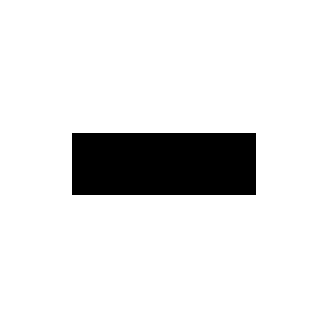

In [6]:
ani1 = animar_patron(blinkr, (5,5), 50)
HTML(ani1.to_jshtml())


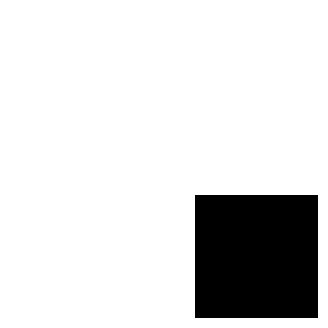

In [7]:
ani2 = animar_patron(glidr, (5,5), 50)
HTML(ani2.to_jshtml())


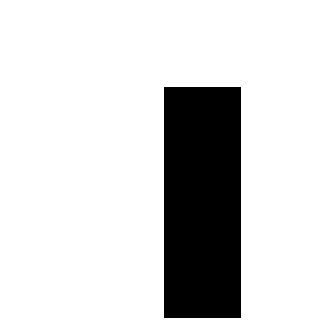

In [8]:
ani3 = animar_patron(toad, (4,4), 50)
HTML(ani3.to_jshtml())


## Observaciones
- Blinker oscila cada 2 pasos entre vertical y horizontal.
- Glider se desplaza diagonalmente.
- Toad alterna su forma de 2×4 cada 2 generaciones.


## Seccion 2: Medición de rendimiento: Juego de
## la vida de Conway

Imports y rutas en la primera celda

In [6]:
# Sección 2: Medición de rendimiento: Juego de la vida de Conway

import json, glob, os
import matplotlib.pyplot as plt

# ── Asegurarnos de estar en la raíz del proyecto ────────────────
# (el notebook vive en notebooks/, así que subimos un nivel)
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
os.chdir(PROJECT_ROOT)

# Rutas de datos
STRONG_JSON  = os.path.join("results", "strong", "strong_512_100.json")
WEAK_PATTERN = os.path.join("results", "weak",   "weak_*.txt")

print("📁 CWD actual:", os.getcwd())
print("🔍 STRONG_JSON  →", STRONG_JSON)
print("🔍 WEAK_PATTERN →", WEAK_PATTERN)



📁 CWD actual: c:\Users\Usuario\Desktop\Tarea #2
🔍 STRONG_JSON  → results\strong\strong_512_100.json
🔍 WEAK_PATTERN → results\weak\weak_*.txt


 Celda para escalamiento fuerte

In [ ]:
with open(STRONG_JSON, "r") as f:
    strong_list = json.load(f)

workers_f = [item["workers"] for item in strong_list]
times_f   = [item["time"]    for item in strong_list]

print("Workers (fuerte):", workers_f)
print("Tiempos  (fuerte):", times_f)



Workers (fuerte): [1, 2, 4, 8]
Tiempos  (fuerte): [34.193153619766235, 25.184422254562378, 21.73913311958313, 28.76968002319336]


Celda para escalamiento débil


In [ ]:
import glob

# patrón de archivos weak
weak_files = sorted(glob.glob(WEAK_PATTERN))

workers_w = []
times_w   = []
for fn in weak_files:
    line = open(fn).read().strip()
    # "workers=1 size=32×32 steps=100 time=34.193s"
    parts = line.split()
    kv = {p.split('=')[0]: p.split('=')[1].rstrip('s') for p in parts}
    workers_w.append(int(kv['workers']))
    times_w.append(float(kv['time']))

print("Workers (débil):", workers_w)
print("Tiempos  (débil):", times_w)


Workers (débil): [1, 2, 4, 8]
Tiempos  (débil): [11.888, 12.641, 15.386, 19.496]


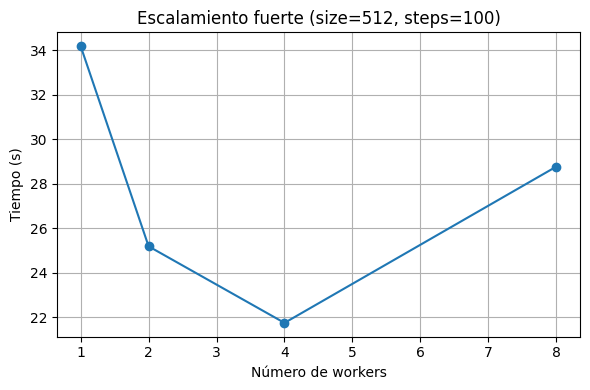

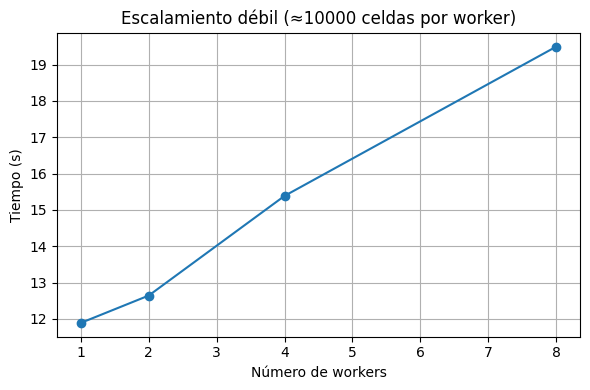

In [11]:
# 4. Gráficas de escalamiento
import matplotlib.pyplot as plt

# Fuerte
plt.figure(figsize=(6,4))
plt.plot(workers_f, times_f, marker='o', linestyle='-')
plt.title(f"Escalamiento fuerte (size={strong_list[0]['size'] if 'size' in strong_list[0] else 512}, steps=100)")
plt.xlabel("Número de workers")
plt.ylabel("Tiempo (s)")
plt.grid(True)
plt.tight_layout()
plt.show()

# Débil
plt.figure(figsize=(6,4))
plt.plot(workers_w, times_w, marker='o', linestyle='-')
plt.title("Escalamiento débil (≈10000 celdas por worker)")
plt.xlabel("Número de workers")
plt.ylabel("Tiempo (s)")
plt.grid(True)
plt.tight_layout()
plt.show()


## Análisis de resultados



### Escalamiento fuerte  
En la gráfica de escalamiento fuerte (size=512, steps=100) observamos que al incrementar el número de procesos de 1 a 4 el tiempo de ejecución disminuye de manera notable, pasando de unos **34 s** a **21.7 s**. Esto indica que el paralelismo compensa el overhead de creación y sincronización de procesos hasta ese punto. Sin embargo, al seguir subiendo a 8 procesos el tiempo vuelve a aumentar (aprox. **28.8 s**), lo que revela que el coste de comunicación y reparto de datos supera el beneficio de tener más workers en esta configuración.


### Escalamiento débil  
En la gráfica de escalamiento débil (≈10000 celdas por proceso) el tiempo de ejecución crece casi linealmente con el número de procesos: de **11.9 s** con 1 proceso a **19.5 s** con 8 procesos. Esto significa que, a igual carga por worker, el overhead de inicializar y coordinar más procesos no se amortiza, y de hecho cada proceso adicional añade más tiempo global. El enfoque de paralelizar por filas funciona, pero sufre penalizaciones cuando la carga por proceso es pequeña.


## Conclusiones

- **Paralelismo útil hasta un límite**: Con hasta 4 procesos logramos acelerar significativamente el cálculo.  
- **Overhead dominante a partir de X procesos**: Más allá de 4 workers, la gestión de procesos y la serialización del estado completa penaliza el rendimiento.  
- **Criterio de partición**: Paralelizar por filas es sencillo, pero transmite el estado completo del grid en cada iteración; estrategias más avanzadas (bloques con fronteras ghost) podrían reducir comunicaciones y mejorar el escalamiento.  
- **Recomendación**: Para tamaño fijo (fuerte), elegir un número de procesos cercano al número de cores físicos; para carga variable (débil), evitar procesos excesivamente pequeños.  